In [1]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...


In [ ]:
data_dir = "pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [ ]:
import os
filename = [data_dir + filename for filename in os.listdir(data_dir)]
filename

['pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 'pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt']

# **PRE-PROCESSING OUR DATA**

In [ ]:
def read_file(filename):
  with open(filename, 'r') as f:
    return f.readlines()

In [ ]:
def preprocess_data(filename):
  lines = read_file(filename)
  abstract_lines = ""
  abstract_list = []

  for i in lines:
    if i.startswith("###"):
      abstract_id = i
      abstract_lines = ""
    elif i.isspace():
      abs_line_split = abstract_lines.splitlines()
      for abs_line_number, abs_line in enumerate(abs_line_split):
        line_data = {}
        target_text = abs_line.split("\t")
        line_data["target"] = target_text[0]
        line_data["data"] = target_text[1].lower()
        line_data["line_number"] = abs_line_number
        line_data["total_line"] = len(abs_line_split)-1
        abstract_list.append(line_data)

    else:
      abstract_lines += i

  return abstract_list

In [ ]:

train_samples = preprocess_data(data_dir + "train.txt")
val_samples = preprocess_data(data_dir + "dev.txt")
test_samples = preprocess_data(data_dir + "test.txt")
len(train_samples), len(val_samples), len(test_samples)


CPU times: user 365 ms, sys: 91.8 ms, total: 457 ms
Wall time: 457 ms


(180040, 30212, 30135)

In [ ]:
import pandas as pd
train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

In [ ]:
train_df.head()

,target,data,line_number,total_line
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [ ]:
train_sen = train_df["data"].tolist()
test_sen = test_df["data"].tolist()
val_sen = val_df["data"].tolist()

# **ONE HOT ENCODING AND LABEL ENCODING OUR TARGET DATAFRAME**

In [ ]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

In [ ]:
ohe = OneHotEncoder(sparse=False)
train_label_OH = ohe.fit_transform(train_df["target"].to_numpy().reshape(-1,1))
test_label_OH = ohe.fit_transform(test_df["target"].to_numpy().reshape(-1,1))
val_label_OH = ohe.fit_transform(val_df["target"].to_numpy().reshape(-1,1))

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df["target"].to_numpy())
val_labels_encoded = label_encoder.transform(val_df["target"].to_numpy())
test_labels_encoded = label_encoder.transform(test_df["target"].to_numpy())

In [ ]:
num_classes = len(label_encoder.classes_)

#**BASELINE(ML) MODEL**

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

In [ ]:
model_0 = Pipeline([
    ("tf-idf",TfidfVectorizer()),
    ("clf",MultinomialNB())
])

In [ ]:
model_0.fit(X=train_sen, y=train_labels_encoded)

Pipeline(steps=[('tf-idf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
model_0.score(X=val_sen,y=val_labels_encoded)

0.7218323844829869

In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def calculate_results(y_true, y_pred):


  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100 # get accuracy score in percentage value
  # Calculate model precision, recall and f1 score using "weighted" avergage
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  # Create a dictionary of model results
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results


In [ ]:
baseline_pred = model_0.predict(val_sen)

In [ ]:
baseline_res = calculate_results(val_labels_encoded,baseline_pred)

In [ ]:
baseline_res

{'accuracy': 72.1832384482987,
 'precision': 0.7186466952323352,
 'recall': 0.7218323844829869,
 'f1': 0.6989250353450294}

#**DEEP LEARNING MODELS**

In [ ]:
import numpy as np
sen_len = [len(sen.split()) for sen in train_sen]
avg_senLen = np.mean(sen_len)
avg_senLen

(array([4.2075e+04, 8.3771e+04, 3.6877e+04, 1.0945e+04, 3.9310e+03,
        1.4450e+03, 5.6000e+02, 2.2600e+02, 1.0100e+02, 4.5000e+01,
        2.0000e+01, 1.2000e+01, 9.0000e+00, 1.0000e+01, 6.0000e+00,
        2.0000e+00, 3.0000e+00, 0.0000e+00, 1.0000e+00, 1.0000e+00]),
 array([  1.  ,  15.75,  30.5 ,  45.25,  60.  ,  74.75,  89.5 , 104.25,
        119.  , 133.75, 148.5 , 163.25, 178.  , 192.75, 207.5 , 222.25,
        237.  , 251.75, 266.5 , 281.25, 296.  ]),
 <BarContainer object of 20 artists>)

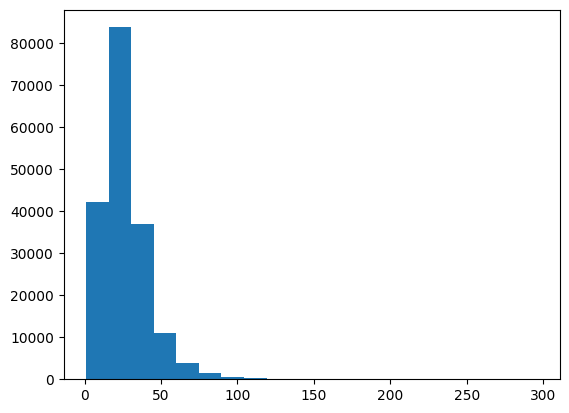

In [ ]:
import matplotlib.pyplot as plt
plt.hist(sen_len, bins=20)

In [ ]:
#finding the token len such that it contains 95% of the samples
seq_len = int(np.percentile(sen_len,95))
seq_len

55

In [ ]:
from tensorflow.keras.layers import TextVectorization

text_vec = TextVectorization(
    max_tokens = 680000,
    output_sequence_length = seq_len
)

In [ ]:
text_vec.adapt(train_sen)

In [ ]:
from tensorflow.keras import layers

embedding = layers.Embedding(input_dim=68000, # set the input shape
                             output_dim=128, # set the size of the embedding vector
                             mask_zero=True
                             )

In [ ]:
import tensorflow as tf
train_dataset = tf.data.Dataset.from_tensor_slices((train_sen, train_label_OH))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sen, test_label_OH))
val_dataset = tf.data.Dataset.from_tensor_slices((val_sen, val_label_OH))

In [ ]:
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset =val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vec(inputs)
x = embedding(x)
x= layers.Conv1D(32,5,padding="same",activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(num_classes,activation="softmax")(x)

model_0 = tf.keras.Model(inputs,output)

In [ ]:
model_0.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVe  (None, 55)                0         
 ctorization)                                                    
                                                                 
 embedding (Embedding)       (None, 55, 128)           8704000   
                                                                 
 conv1d_1 (Conv1D)           (None, 55, 32)            20512     
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
  (GlobalAveragePooling1D)                                       
                                                                 
 dense (Dense)               (None, 5)                 165   

In [ ]:
history_model_1 = model_0.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset))) # only validate on 10% of batches


Epoch 1/3
562/562 [==============================] - 24s 30ms/step - loss: 0.9669 - accuracy: 0.6156 - val_loss: 0.7017 - val_accuracy: 0.7350
Epoch 2/3
562/562 [==============================] - 5s 9ms/step - loss: 0.6598 - accuracy: 0.7570 - val_loss: 0.6391 - val_accuracy: 0.7723
Epoch 3/3
562/562 [==============================] - 5s 10ms/step - loss: 0.6177 - accuracy: 0.7754 - val_loss: 0.5990 - val_accuracy: 0.7806


In [ ]:
model_0.evaluate(val_dataset)

945/945 [==============================] - 6s 6ms/step - loss: 0.5996 - accuracy: 0.7857


[0.5995973944664001, 0.7857474088668823]

In [ ]:
history_model_2 = model_0.fit(train_dataset,

                              validation_data=val_dataset,
                              epochs=5) # only validate on 10% of batches


Epoch 1/5
5627/5627 [==============================] - 62s 11ms/step - loss: 0.2300 - accuracy: 0.9267 - val_loss: 0.7315 - val_accuracy: 0.7903
Epoch 2/5
5627/5627 [==============================] - 38s 7ms/step - loss: 0.1972 - accuracy: 0.9381 - val_loss: 0.8100 - val_accuracy: 0.7855
Epoch 3/5
5627/5627 [==============================] - 38s 7ms/step - loss: 0.1664 - accuracy: 0.9488 - val_loss: 0.8975 - val_accuracy: 0.7786
Epoch 4/5
5627/5627 [==============================] - 40s 7ms/step - loss: 0.1397 - accuracy: 0.9582 - val_loss: 0.9963 - val_accuracy: 0.7737
Epoch 5/5
5627/5627 [==============================] - 40s 7ms/step - loss: 0.1163 - accuracy: 0.9660 - val_loss: 1.1050 - val_accuracy: 0.7675


In [ ]:
import tensorflow_hub as hub
sent_encoder = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        trainable=False,
                                        name="universal_sentence_encoder")

In [ ]:
inputs = layers.Input(shape=[], dtype=tf.string)
embed = sent_encoder(inputs)
x = layers.Dense(128, activation="relu")(embed)
output = layers.Dense(num_classes, activation="softmax")(x)
model_1 = tf.keras.Model(inputs, output)


In [ ]:
model_1.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_1.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None,)]                 0         
                                                                 
 universal_sentence_encoder  (None, 512)               256797824 
  (KerasLayer)                                                   
                                                                 
 dense_6 (Dense)             (None, 128)               65664     
                                                                 
 dense_7 (Dense)             (None, 5)                 645       
                                                                 
Total params: 256864133 (979.86 MB)
Trainable params: 66309 (259.02 KB)
Non-trainable params: 256797824 (979.61 MB)
_________________________________________________________________


In [ ]:
history_model_2 = model_1.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_dataset)))

Epoch 1/3
562/562 [==============================] - 19s 15ms/step - loss: 0.9197 - accuracy: 0.6470 - val_loss: 0.7983 - val_accuracy: 0.6892
Epoch 2/3
562/562 [==============================] - 6s 11ms/step - loss: 0.7698 - accuracy: 0.7011 - val_loss: 0.7556 - val_accuracy: 0.7041
Epoch 3/3
562/562 [==============================] - 8s 14ms/step - loss: 0.7518 - accuracy: 0.7115 - val_loss: 0.7385 - val_accuracy: 0.7144


In [ ]:
model_1.evaluate(val_dataset)

945/945 [==============================] - 19s 20ms/step - loss: 0.7405 - accuracy: 0.7142


[0.7404918074607849, 0.7141532897949219]

In [ ]:
model_1_pred = tf.argmax(model_1.predict(val_dataset),axis=1)
model_1_pred

945/945 [==============================] - 10s 10ms/step


<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 3, ..., 4, 4, 2])>

In [ ]:
model_1_res = calculate_results(val_labels_encoded, model_1_pred)

In [ ]:
model_1_res

{'accuracy': 71.4153316562955,
 'precision': 0.7143750691715887,
 'recall': 0.7141533165629551,
 'f1': 0.7114853539536738}

##**CHARACTER LEVEL EMBEDDINGS**

In [ ]:
def split_char(text):
  return " ".join(list(text))

In [ ]:
res = split_char(train_sen[5])
res

's e r u m   l e v e l s   o f   i n t e r l e u k i n   @   (   i l - @   )   ,   i l - @   ,   t u m o r   n e c r o s i s   f a c t o r   (   t n f   )   -   ,   a n d   h i g h - s e n s i t i v i t y   c - r e a c t i v e   p r o t e i n   (   h s c r p   )   w e r e   m e a s u r e d   .'

In [ ]:
train_chars = [split_char(sentence) for sentence in train_sen]
train_chars[:5]

['t o   i n v e s t i g a t e   t h e   e f f i c a c y   o f   @   w e e k s   o f   d a i l y   l o w - d o s e   o r a l   p r e d n i s o l o n e   i n   i m p r o v i n g   p a i n   ,   m o b i l i t y   ,   a n d   s y s t e m i c   l o w - g r a d e   i n f l a m m a t i o n   i n   t h e   s h o r t   t e r m   a n d   w h e t h e r   t h e   e f f e c t   w o u l d   b e   s u s t a i n e d   a t   @   w e e k s   i n   o l d e r   a d u l t s   w i t h   m o d e r a t e   t o   s e v e r e   k n e e   o s t e o a r t h r i t i s   (   o a   )   .',
 'a   t o t a l   o f   @   p a t i e n t s   w i t h   p r i m a r y   k n e e   o a   w e r e   r a n d o m i z e d   @ : @   ;   @   r e c e i v e d   @   m g / d a y   o f   p r e d n i s o l o n e   a n d   @   r e c e i v e d   p l a c e b o   f o r   @   w e e k s   .',
 'o u t c o m e   m e a s u r e s   i n c l u d e d   p a i n   r e d u c t i o n   a n d   i m p r o v e m e n t   i n   f u n c t i o n   s c o r e s   a 

In [ ]:
val_chars = [split_char(sentence) for sentence in val_sen]
test_chars = [split_char(sentence) for sentence in test_sen]

In [ ]:
train_char_data = tf.data.Dataset.from_tensor_slices((train_chars,train_label_OH)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_data = tf.data.Dataset.from_tensor_slices((test_chars,test_label_OH)).batch(32).prefetch(tf.data.AUTOTUNE)
val_char_data = tf.data.Dataset.from_tensor_slices((val_chars,val_label_OH)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
import numpy as np
char_len = [len(sen) for sen in train_sen]
avg_char_len = np.mean(char_len)
avg_char_len

149.3662574983337

In [ ]:
output_char_seq_len = int(np.percentile(char_len,95))
output_char_seq_len

290

In [ ]:
import string
alphabet = string.ascii_lowercase + string.digits + string.punctuation
len(alphabet)

68

In [ ]:
char_tokens = len(alphabet)+2

In [ ]:
char_vectorizer = TextVectorization(max_tokens= char_tokens,
                                    output_sequence_length=output_char_seq_len,
                                    standardize="lower_and_strip_punctuation",
                                    name="char_vectorizer")

# Adapt character vectorizer to training characters
char_vectorizer.adapt(train_chars)

In [ ]:
char_embed = layers.Embedding(input_dim=char_tokens, # set the input shape
                             output_dim=25, # set the size of the embedding vector
                             mask_zero=True,
                              name="char_embed"
                             )

In [ ]:
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embed(x)
x= layers.Conv1D(64,5,padding="same",activation="relu")(x)
x = layers.GlobalMaxPooling1D()(x)
output = layers.Dense(num_classes,activation="softmax")(x)

model_3 = tf.keras.Model(inputs,output)

In [ ]:
model_3.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_3.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 char_vectorizer (TextVecto  (None, 290)               0         
 rization)                                                       
                                                                 
 char_embed (Embedding)      (None, 290, 25)           1750      
                                                                 
 conv1d (Conv1D)             (None, 290, 64)           8064      
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 5)                 325   

In [ ]:
hist_model_3 = model_3.fit(train_char_data,
                          validation_data = val_char_data,
                          epochs=5)

Epoch 1/5
5627/5627 [==============================] - 38s 6ms/step - loss: 0.9038 - accuracy: 0.6472 - val_loss: 0.8098 - val_accuracy: 0.6831
Epoch 2/5
5627/5627 [==============================] - 31s 6ms/step - loss: 0.7540 - accuracy: 0.7128 - val_loss: 0.7588 - val_accuracy: 0.7078
Epoch 3/5
5627/5627 [==============================] - 31s 5ms/step - loss: 0.7136 - accuracy: 0.7299 - val_loss: 0.7293 - val_accuracy: 0.7197
Epoch 4/5
5627/5627 [==============================] - 32s 6ms/step - loss: 0.6864 - accuracy: 0.7416 - val_loss: 0.7141 - val_accuracy: 0.7276
Epoch 5/5
5627/5627 [==============================] - 31s 6ms/step - loss: 0.6691 - accuracy: 0.7495 - val_loss: 0.7038 - val_accuracy: 0.7334


In [ ]:
history_model_3 = model_3.fit(train_dataset,
                              steps_per_epoch=int(0.1*len(train_char_data)),
                              epochs=3,
                              validation_data=val_dataset,
                              validation_steps=int(0.1 * len(val_char_data)))

Epoch 1/3
562/562 [==============================] - 4s 7ms/step - loss: 1.3456 - accuracy: 0.4262 - val_loss: 1.3379 - val_accuracy: 0.4392
Epoch 2/3
562/562 [==============================] - 3s 5ms/step - loss: 1.3293 - accuracy: 0.4267 - val_loss: 1.3271 - val_accuracy: 0.4398
Epoch 3/3
562/562 [==============================] - 3s 6ms/step - loss: 1.3241 - accuracy: 0.4382 - val_loss: 1.3218 - val_accuracy: 0.4415


In [ ]:
model_3_pred = tf.argmax(model_3.predict(val_char_data),axis=1)

945/945 [==============================] - 3s 3ms/step


In [ ]:
res = calculate_results(val_labels_encoded, model_3_pred)

In [ ]:
res

{'accuracy': 64.56374950350853,
 'precision': 0.6782268624092723,
 'recall': 0.6456374950350854,
 'f1': 0.5878779552750117}

#**MULTIMODAL MODEL**

In [ ]:
token_inputs = layers.Input(shape=[], dtype = tf.string)
x = sent_encoder(token_inputs)
token_output = layers.Dense(128, activation="relu")(x)

token_model = tf.keras.Model(token_inputs,token_output)

In [ ]:
char_input = layers.Input(shape=(1,), dtype=tf.string)
char_vector = char_vectorizer(char_input)
char_embedding = char_embed(char_vector)
x = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_input,x)

In [ ]:
concat_layer = layers.Concatenate(name = "token_char_hybrid")([token_model.output, char_model.output])

In [ ]:
x = layers.Dropout(0.5)(concat_layer)
x = layers.Dense(256, activation="relu")(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(num_classes, activation="softmax")(x)

In [ ]:
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                     outputs=output)

In [ ]:
model_4.compile(loss="categorical_crossentropy",
                optimizer="Adam",
                metrics=["accuracy"])

model_4.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 1)]                  0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['input_3[0][0]']             
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['input_2[0][0]']       

COMBINING CHAR AND TOKEN DATASETS

In [ ]:
train_data_final = tf.data.Dataset.from_tensor_slices((train_sen, train_chars))
train_label_final = tf.data.Dataset.from_tensor_slices(train_label_OH)
train_dataset_final = (tf.data.Dataset.zip((train_data_final, train_label_final))).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_data_final = tf.data.Dataset.from_tensor_slices((val_sen, val_chars))
val_label_final = tf.data.Dataset.from_tensor_slices(val_label_OH)
val_dataset_final = (tf.data.Dataset.zip((val_data_final, val_label_final))).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_data_final = tf.data.Dataset.from_tensor_slices((test_sen, test_chars))
test_label_final = tf.data.Dataset.from_tensor_slices(test_label_OH)
test_dataset_final = (tf.data.Dataset.zip((test_data_final, test_label_final))).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
train_dataset_final

<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [ ]:
history_model_4 = model_4.fit(train_dataset_final,
                              steps_per_epoch=int(0.1*len(train_dataset_final)),
                              epochs=5,
                              validation_data=val_dataset_final,
                              validation_steps=int(0.1 * len(val_dataset_final)))

Epoch 1/5
562/562 [==============================] - 48s 51ms/step - loss: 0.9615 - accuracy: 0.6152 - val_loss: 0.7685 - val_accuracy: 0.7081
Epoch 2/5
562/562 [==============================] - 27s 47ms/step - loss: 0.7882 - accuracy: 0.6929 - val_loss: 0.7108 - val_accuracy: 0.7360
Epoch 3/5
562/562 [==============================] - 26s 46ms/step - loss: 0.7663 - accuracy: 0.7055 - val_loss: 0.6916 - val_accuracy: 0.7414
Epoch 4/5
562/562 [==============================] - 27s 48ms/step - loss: 0.7335 - accuracy: 0.7221 - val_loss: 0.6652 - val_accuracy: 0.7497
Epoch 5/5
562/562 [==============================] - 26s 46ms/step - loss: 0.7364 - accuracy: 0.7165 - val_loss: 0.6537 - val_accuracy: 0.7460


In [ ]:
model_4.evaluate(val_dataset_final)

945/945 [==============================] - 30s 32ms/step - loss: 0.6637 - accuracy: 0.7447


[0.6637133359909058, 0.7446709871292114]

In [ ]:
model_4_pred = tf.argmax(model_4.predict(val_dataset_final),axis=1)

945/945 [==============================] - 21s 19ms/step


In [ ]:
model_4_res = calculate_results(val_labels_encoded, model_4_pred)

In [ ]:
model_4_res

{'accuracy': 74.46709916589434,
 'precision': 0.7442121716131139,
 'recall': 0.7446709916589435,
 'f1': 0.7386371901209492}

**create positional embeddings**

In [ ]:
train_df["line_number"].shape

(180040,)

In [ ]:
train_line_numbers_OH = tf.one_hot(train_df["line_number"].to_numpy(), depth=15)
val_line_numbers_OH = tf.one_hot(val_df["line_number"].to_numpy(), depth=15)
test_line_numbers_OH = tf.one_hot(test_df["line_number"].to_numpy(), depth=15)

In [ ]:
train_total_lines_OH = tf.one_hot(train_df["total_line"].to_numpy(), depth=20)
val_total_lines_OH = tf.one_hot(val_df["total_line"].to_numpy(), depth=20)
test_total_lines_OH = tf.one_hot(test_df["total_line"].to_numpy(), depth=20)

#**TRIBRID MODEL**

In [ ]:
token_inputs = layers.Input(shape=[], dtype = tf.string, name="token_input")
x = sent_encoder(token_inputs)
token_output = layers.Dense(128, activation="relu")(x)
token_model = tf.keras.Model(token_inputs,token_output)



char_input = layers.Input(shape=(1,), dtype=tf.string, name= "char_input")
char_vector = char_vectorizer(char_input)
char_embedding = char_embed(char_vector)
x = layers.Bidirectional(layers.LSTM(24))(char_embedding)
char_model = tf.keras.Model(char_input,x)


input = layers.Input(shape=(15,), dtype=tf.int32, name="line_num_ip")
x = layers.Dense(32, activation="relu")(input)
line_num_model = tf.keras.Model(input,x)


input = layers.Input(shape=(20,), dtype=tf.int32, name="total line ip")
x = layers.Dense(32, activation="relu")(input)
total_line_model = tf.keras.Model(input,x)


combined_embed_layer = layers.Concatenate(name = "token_char_hybrid")([token_model.output, char_model.output])

x = layers.Dense(128, activation="relu")(combined_embed_layer)
x = layers.Dropout(0.5)(x)


positional_embed = layers.Concatenate(name="token_char_positional")([line_num_model.output, total_line_model.output, x])

output_layer = layers.Dense(num_classes, activation="softmax")(positional_embed)

model_5 = tf.keras.Model(inputs=[line_num_model.input,
                                 total_line_model.input,
                                 token_model.input,
                                 char_model.input],
                         outputs=output_layer)

In [ ]:
model_5.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 char input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 token input (InputLayer)    [(None,)]                    0         []                            
                                                                                                  
 char_vectorizer (TextVecto  (None, 290)                  0         ['char input[0][0]']          
 rization)                                                                                        
                                                                                                  
 universal_sentence_encoder  (None, 512)                  2567978   ['token input[0][0]']   

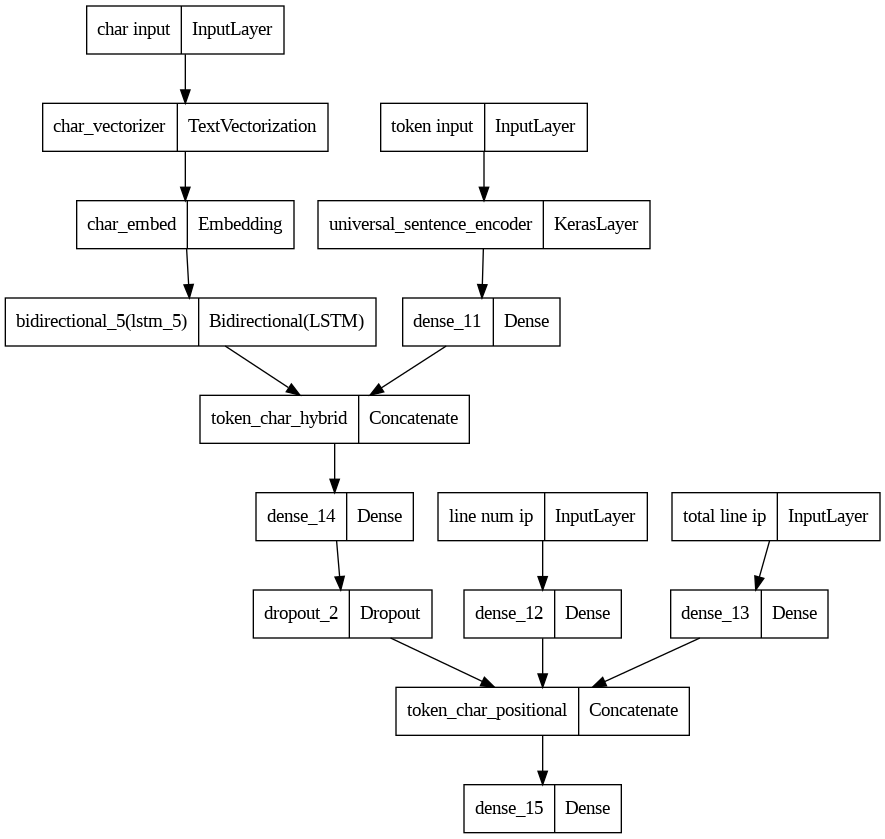

In [ ]:
plot_model(model_5)

In [ ]:
model_5.compile(loss= tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2),
                optimizer="Adam",
                metrics=["accuracy"])

In [ ]:
train_pos_data = tf.data.Dataset.from_tensor_slices((train_line_numbers_OH, train_total_lines_OH, train_sen, train_chars))
train_pos_label = tf.data.Dataset.from_tensor_slices(train_label_OH)
train_pos_dataset = (tf.data.Dataset.zip((train_pos_data, train_pos_label))).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
val_pos_data = tf.data.Dataset.from_tensor_slices((val_line_numbers_OH, val_total_lines_OH, val_sen, val_chars))
val_pos_label = tf.data.Dataset.from_tensor_slices(val_label_OH)
val_pos_dataset = (tf.data.Dataset.zip((val_pos_data, val_pos_label))).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
test_pos_data = tf.data.Dataset.from_tensor_slices((test_line_numbers_OH, test_total_lines_OH, test_sen, test_chars))
test_pos_label = tf.data.Dataset.from_tensor_slices(test_label_OH)
test_pos_dataset = (tf.data.Dataset.zip((test_pos_data, test_pos_label))).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
final_model = model_5.fit(train_pos_dataset,
                          epochs=10,
                          validation_data=val_pos_dataset)

Epoch 1/10
5627/5627 [==============================] - 290s 47ms/step - loss: 0.9607 - accuracy: 0.8194 - val_loss: 0.9122 - val_accuracy: 0.8467
Epoch 2/10
5627/5627 [==============================] - 260s 46ms/step - loss: 0.9151 - accuracy: 0.8512 - val_loss: 0.9009 - val_accuracy: 0.8533
Epoch 3/10
5627/5627 [==============================] - 257s 46ms/step - loss: 0.9024 - accuracy: 0.8603 - val_loss: 0.8990 - val_accuracy: 0.8535
Epoch 4/10
5627/5627 [==============================] - 255s 45ms/step - loss: 0.8944 - accuracy: 0.8668 - val_loss: 0.8956 - val_accuracy: 0.8558
Epoch 5/10
5627/5627 [==============================] - 254s 45ms/step - loss: 0.8876 - accuracy: 0.8710 - val_loss: 0.8975 - val_accuracy: 0.8555
Epoch 6/10
5627/5627 [==============================] - 255s 45ms/step - loss: 0.8821 - accuracy: 0.8753 - val_loss: 0.8963 - val_accuracy: 0.8552
Epoch 7/10
5627/5627 [==============================] - 258s 46ms/step - loss: 0.8778 - accuracy: 0.8788 - val_loss: 0

In [ ]:
model_5.evaluate(val_pos_dataset)

945/945 [==============================] - 23s 25ms/step - loss: 0.8987 - accuracy: 0.8553


[0.8987120389938354, 0.855256199836731]

In [ ]:
model_5_pred = tf.argmax(model_5.predict(val_pos_dataset),axis=1)
res = calculate_results(val_labels_encoded, model_5_pred)
res

945/945 [==============================] - 24s 25ms/step


{'accuracy': 85.5256189593539,
 'precision': 0.8571586260146912,
 'recall': 0.855256189593539,
 'f1': 0.8524162943796922}